In [1]:
import sys
sys.path.append("./modules")


In [2]:
# Import general modules
from nansat import Nansat, Domain, NSR
import os 
#for calculating time difference
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator
import pandas as pd

# Import temporal modules needed for testing plotting
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Import SAR forecasting modules
import config
import s1_preparation
import SAR1_SAR2_drift_retrivial
import warping_with_domain
import domains_preparation
import model_data_proces

# Import variables
from config import path_to_HH_files, path_to_HV_files, safe_folder 
from config import output_folder, input_folder
from config import S1_prod_regex, S1_safe_regex
from config import lon, lat, X, Y, proj4, srs

# For cleaning up memory
import gc

In [3]:
# 1. Prepare SAR pairs

# Collect Sentinel SAFE objects for files in safe directory.
safe_objects = s1_preparation.collect_sentinel_files(safe_folder, path_to_HH_files, path_to_HV_files,  S1_safe_regex, S1_prod_regex)

# Get pairs of Sentinel SAFE objects where their timestamps are within 50 hours of each other.
sar_pairs = s1_preparation.get_pairs_within_time_limit(safe_objects, hours = 50)

# Print details for each pair.
for index, pair in enumerate(sar_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1.SAFE 
timestamp: 2022-11-20 08:01:55
SAR2: S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9.SAFE 
timestamp: 2022-11-22 07:45:35
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20221207T081027_20221207T081131_046223_0588F0_3669.SAFE 
timestamp: 2022-12-07 08:10:27
SAR2: S1A_EW_GRDM_1SDH_20221209T075358_20221209T075502_046252_0589D9_984C.SAFE 
timestamp: 2022-12-09 07:53:58
Pair 3:
SAR1: S1A_EW_GRDM_1SDH_20221226T080153_20221226T080257_046500_059247_AF72.SAFE 
timestamp: 2022-12-26 08:01:53
SAR2: S1A_EW_GRDM_1SDH_20221228T074533_20221228T074637_046529_05934F_9B36.SAFE 
timestamp: 2022-12-28 07:45:33
Pair 4:
SAR1: S1A_EW_GRDM_1SDH_20230107T080152_20230107T080257_046675_059829_112D.SAFE 
timestamp: 2023-01-07 08:01:52
SAR2: S1A_EW_GRDM_1SDH_20230109T074532_20230109T074637_046704_05992E_8779.SAFE 
timestamp: 2023-01-09 07:45:32
Pair 5:
SAR1: S1A_EW_GRDM_1SDH_20230119T080151_20230119T080256_046850_059E12_340

In [4]:
# 2.1. Prepare nansat objects and domains (for each sar pair)

#Prepare nansat objects for HV polarisation
n1_hv, n2_hv, output_dir_name, plots_dir_hv =  domains_preparation.prepare_nansat_objects(sar_pairs[0][0], sar_pairs[0][1], output_folder, polarisation='HV')

#Prepare nansat objects for HH polarisation
n1_hh, n2_hh, output_dir_name, plots_dir_hh =  domains_preparation.prepare_nansat_objects(sar_pairs[0][0], sar_pairs[0][1], output_folder, polarisation='HH')




VMIN:  -4.306089925765991
VMAX:  6.399863028526303
VMIN:  -4.0071940422058105
VMAX:  6.065964317321773
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20221120T080155_20221122T074535
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20221120T080155_20221122T074535/HV_plots
VMIN:  -3.387907314300537
VMAX:  4.770930914878845
VMIN:  -3.8385958671569824
VMAX:  4.498740539550779
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20221120T080155_20221122T074535
Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20221120T080155_20221122T074535/HH_plots


In [5]:
# 2.2  Define model domain (mod_dom) for comparing drift and comparison (dst_dom) domain to compare SAR images (real and forecasted)

# Prepare subset model grid for domains and pattern matching
X_subset, Y_subset, lon_subset, lat_subset, min_row, max_row, min_col, max_col = domains_preparation.prepare_grid(n1_hv, n2_hv, srs, X, Y, lon, lat, buffer=0)

# Set a model domain
mod_res = 2500
mod_dom = Domain(srs, f'-te {min(X_subset)} {min(Y_subset) - mod_res * 2} {max(X_subset) + mod_res} {max(Y_subset)} -tr {mod_res} {mod_res}')


lon1pm, lat1pm = mod_dom.get_geolocation_grids()
x, y = mod_dom.get_geolocation_grids(dst_srs=srs)

# Set a comparison domain 
dst_res = 100
dst_dom = Domain(srs, f'-te {min(X_subset)} {min(Y_subset) - dst_res * 2} {max(X_subset) + dst_res} {max(Y_subset)} -tr {dst_res} {dst_res}')

domains_preparation.plot_borders(mod_dom, n1_hv, n2_hv, output_dir_name) # borders for hh and hv are the same

'/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20221120T080155_20221122T074535/General_plots/images_vs_domain_borders.png'

In [6]:
# Checking that domains have the same borders 

rows1, cols1 = dst_dom.shape()
print("dst_dom corner coordinates:", dst_dom.transform_points([0,cols1-1,0,cols1-1], [0,0,rows1-1,rows1-1], dst_srs=srs))

rows1, cols1 = mod_dom.shape()
print("mod_dom corner coordinates:", mod_dom.transform_points([0,cols1-1,0,cols1-1], [0,0,rows1-1,rows1-1], dst_srs=srs))

dst_dom corner coordinates: (array([278603.1875, 823603.1875, 278603.1875, 823603.1875]), array([774568.375, 774568.375,  69568.375,  69568.375]))
mod_dom corner coordinates: (array([278603.1875, 823603.1875, 278603.1875, 823603.1875]), array([774568.375, 774568.375,  69568.375,  69568.375]))


In [7]:
# 3. Retrieve model drift data for the subset

# 3.1. Extract teh time period based on teh SAR pair timestamp

# SAR images timestamps
t_sar1 = sar_pairs[0][0].timestamp
t_sar2 = sar_pairs[0][1].timestamp

# Rounding the SAR timestamps to align with the nearest whole hour of model timestamps
t_start = model_data_proces.round_start_time(t_sar1)
t_end = model_data_proces.round_end_time(t_sar2)

print(f'SAR1 time is {t_sar1}, Model start time for the time period is {t_start}')
print(f'SAR2 time is {t_sar2}, Model end time for the time period is {t_end}')

# 3.2. Set the time period for extracting hourly model data

time_period = pd.date_range(t_start, t_end, freq='H')

# 3.3. Calculate the difference between model start and end time and SAR1 and SAR2 timestamps
time_diff_start, time_diff_end, total_time_diff = model_data_proces.time_difference(t_sar1, t_sar2,  t_start, t_end)

SAR1 time is 2022-11-20 08:01:55, Model start time for the time period is 2022-11-20 08:00:00
SAR2 time is 2022-11-22 07:45:35, Model end time for the time period is 2022-11-22 08:00:00
Time difference between SAR1 and the start of the model time period is 115 seconds (1.92 minutes).
Time difference between SAR2 and the end of the model time period is 865 seconds (14.42 minutes).
Total time difference between SAR1 and SAR2 images is 85420 seconds (23.73 hours).


In [8]:
jt = model_data_proces.JohannesroThredds()

In [9]:
# 3.4. Calculate a rolling average

avg_ice_u, avg_ice_v =  model_data_proces.rolling_avg_24_ensembles(jt, time_period, min_row, max_row, min_col, max_col)

/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/model_data_proces.py:223: RuntimeWarning: Mean of empty slice
  avg_ice_u.append(np.nanmean(data['ice_u'], axis=0))
/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/model_data_proces.py:224: RuntimeWarning: Mean of empty slice
  avg_ice_v.append(np.nanmean(data['ice_v'], axis=0))
/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/model_data_proces.py:223: RuntimeWarning: Mean of empty slice
  avg_ice_u.append(np.nanmean(data['ice_u'], axis=0))
/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/model_data_proces.py:224: RuntimeWarning: Mean of empty slice
  avg_ice_v.append(np.nanmean(data['ice_v'], axis=0))
/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/model_data_proces.py:223: RuntimeWarning: Mean of empty slice
  avg_ice_u.append(np.nanmean(data['ice_u'], axis=0))
/home/jovyan/packages/2022-2023_48h_experiment/one

In [35]:
'''
def cumulative_ice_displacement(X, Y, x, y, ice_u, ice_v, time_period, time_diff_start, time_diff_end):
    """
    Computes the integrated displacement along the x and y axes for each hour (or its fraction) of the forecasting  time period. 
    The calculation for each hour is cumulative. For instance, the displacement value at the 1st hour represents the displacement 
    for that hour alone, while the value at the 5th hour represents the cumulative displacement over the first five hours.
    Such displacmeents are intended for drift-driven warping
    
    This function also derives the hourly coordinates (xx and yy) in the Lagrangian reference frame, where the model coordinates 
    X and Y serve as the starting grid coordinates.

    Parameters:
    - X, Y (DataArray): Cartesian coordinates from the model or its subset.
    - ice_u, ice_v (DataArray): Ice velocities along the x and y axes, respectively.
    - time_period (DataArray): The input xarray model time period.
    - time_diff_start (int): Time difference in seconds between SAR1 and the start of the model time period.
    - time_diff_end (int): Time difference in seconds between SAR2 and the end of the model time period.

    Returns: 
    - xx, yy (list): Lists of coordinates corresponding to each timestamp in the time period. The lengths of xx and yy are equivalent to len(time_period).
    - int_dx, int_dy (list): Lists of total cumulative displacements for each hour of the time period. The lengths of int_dx and int_dy are len(time_period) - 1.
    """


    # Create coordinate arrays  
    x_sub, y_sub = x, y
    # Store the shape of the original arrays
    shape = x.shape
    # Turn arrays into vectors
    x_sub = x_sub.flatten()
    y_sub = y_sub.flatten()

    # Store the selected coordinate arrays in lists to collect arrays from different iterations for further processing
    xx = [x_sub]
    yy = [y_sub]

    # Prepare lists for integrated drift for comparison with model
    int_dx = []
    int_dy = []

    for t in range(1, len(time_period)):
        #print(f'{t} hour done')

        # Clip y_stp and x_stp to ensure they are within the bounds of the coordinate grid
        #y_stp = np.clip(y_stp, np.min(Y_stp.data), np.max(Y_stp.data))
        #x_stp = np.clip(x_stp, np.min(X_stp.data), np.max(X_stp.data))

        # Extract instantaneous velocity data for the hour start and end using polygon mask for area of interest
        if np.any(np.isfinite(ice_u[t-1])):
            u1 = ice_u[t-1]
        if np.any(np.isfinite(ice_u[t])):
            u2 = ice_u[t]
 
        if np.any(np.isfinite(ice_u[t-1])):
            v1 = ice_v[t-1]
        if np.any(np.isfinite(ice_u[t])):
            v2 = ice_v[t]

        # Calculate displacement along lon (u) and lat (v) based on mean velovity
        # The first and the last displacemnets are calculated differently based on time difference with the SAR acquisitions
        if t == 1:
            u_displacement = (u2+u1)*(3600-time_diff_start)/2
            v_displacement = (v2+v1)*(3600-time_diff_start)/2
            #print("start", t, u_displacement.values)
        elif t in range(2, len(time_period)-1):
            u_displacement = (u2+u1)*3600/2
            v_displacement = (v2+v1)*3600/2
            #print(t, u_displacement.values)
        elif t == len(time_period)-1:
            u_displacement = (u2+u1)*(3600-time_diff_end)/2
            v_displacement = (v2+v1)*(3600-time_diff_end)/2
            #print("end", t, u_displacement.values)

        # Create interpolator object with grid coordinates and corresponded drift values
        ut_interpolator = RegularGridInterpolator((Y,X), u_displacement, bounds_error=False, fill_value = None)
        dx = ut_interpolator((y_sub, x_sub))
        #print("dx", dx)
        vt_interpolator = RegularGridInterpolator((Y,X), v_displacement, bounds_error=False, fill_value = None)
        dy = vt_interpolator((y_sub, x_sub)) 
        #print("dy", dy)
        # Calculate new coordinates based on displacement 
        x_sub = x_sub + dx
        y_sub = y_sub + dy
        # Append them to the list
        xx.append(x_sub)
        yy.append(y_sub)


        #Calculate total integrated drift
        if t == 1:
            dx_total = dx
            dy_total = dy
            int_dx.append(dx_total)
            int_dy.append(dy_total)
        else:
            dx_total = int_dx[-1] + dx
            dy_total = int_dy[-1] + dy
            int_dx.append(dx_total)
            int_dy.append(dy_total)
            
    return xx, yy, int_dx, int_dy
'''

In [10]:
xx_b_subset, yy_b_subset, cum_dx_b_subset, cum_dy_b_subset = model_data_proces.cumulative_ice_displacement(X_subset, Y_subset, x, y, avg_ice_u, avg_ice_v, time_period, time_diff_start,time_diff_end)

In [12]:
# 3.6. Get the final integrated displacement
model_u = np.reshape(cum_dx_b_subset[-1], x.shape)
model_v = np.reshape(cum_dy_b_subset[-1], x.shape)
x2 = np.reshape(xx_b_subset[-1], x.shape)
y2 = np.reshape(yy_b_subset[-1], x.shape)

In [13]:
# 3.7. Save final drift, its parameters to npy files
save_name = 'mod_drift_output'
sar_drift_output_path = SAR1_SAR2_drift_retrivial.save_sar_drift_results(output_dir_name, save_name,
                                                                         model_u=model_u, model_v=model_v,
                                                                         y2=y2, x2=x2)

Arrays saved to /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20221120T080155_20221122T074535/mod_drift_output/mod_drift_output.npz


In [14]:
# 4. Warp SAR1 image with the reference sar drift and compare all arrays in the comparison distination domain

# 4.1. Warp
# Warp SAR1 with SAR-drift compenstaion/displacement
# Create individual masks for non-NaN values in each array
mask_u = np.isnan(model_u)
mask_v = np.isnan(model_v)
mask = mask_u & mask_v # mask out low quality or NaN
s1_dst_dom_S_hv = warping_with_domain.warp_with_uv(n1_hv, n1_hv[1], mod_dom, model_u, model_v, mask, dst_dom)
s1_dst_dom_S_hh = warping_with_domain.warp_with_uv(n1_hh, n1_hh[1], mod_dom, model_u, model_v, mask, dst_dom)

# Warp SAR2 to the comparison domain
s2_dst_dom_hv = warping_with_domain.warp(n2_hv, n2_hv[1], dst_dom)
s2_dst_dom_hh = warping_with_domain.warp(n2_hh, n2_hh[1], dst_dom)

# Warp SAR1 to the comparison domain for visualisation
s1_dst_dom_hv = warping_with_domain.warp(n1_hv, n1_hv[1], dst_dom)
s1_dst_dom_hh = warping_with_domain.warp(n1_hh, n1_hh[1], dst_dom)

In [15]:
# 4.2. Plot warping results

# Create General plots folder if it doesn't exist already (but it should)
general_save_path = os.path.join(output_dir_name, "General_plots")
os.makedirs(general_save_path, exist_ok=True)


warping_with_domain.plot_sar_forecast_images(general_save_path, 
                                             "Forecast_with_mod_ref_drift", 
                                             s1_dst_dom_hv, s2_dst_dom_hv, s1_dst_dom_S_hv,
                                             s1_dst_dom_hh, s2_dst_dom_hh, s1_dst_dom_S_hh,
                                             gamma_value=1.2)

In [19]:
# 5. Calculate quality parametrs (corr, hess, ssim) for the predicted SAR2 (by calculating pattern matchin on SAR2 and SAR2_predicted)

# 5.1. Make new nansat objects for comparison

n_s1_predict = Nansat.from_domain(dst_dom, array = s1_dst_dom_S_hv)
n_s2 = Nansat.from_domain(dst_dom, array = s2_dst_dom_hv)

# 5.2. Create directory for saving plots 
comparison_dir = os.path.join(output_dir_name, f"Model_distortion_error")
try:
    os.makedirs(comparison_dir, exist_ok=True)
    print(f"Successfully created {comparison_dir}")
except Exception as e:
    print(f"Failed to create {comparison_dir}. Error: {e}")
    
# Calculate realibility indexes 

# 5.4. Run feature tracking and plot results 
c1_alg_hv, r1_alg_hv, c2_alg_hv, r2_alg_hv = SAR1_SAR2_drift_retrivial.run_feature_tracking(n_s1_predict, n_s2, comparison_dir)

# 5.5. Run pattern matching and plot results
upm_alg_hv, vpm_alg_hv, apm_alg_hv, rpm_alg_hv, hpm_alg_hv, ssim_alg_hv, lon2pm_alg_hv, lat2pm_alg_hv = SAR1_SAR2_drift_retrivial.run_pattern_matching(comparison_dir, x, y, 
                                                           lon1pm, lat1pm, n_s1_predict, c1_alg_hv, r1_alg_hv, n_s2, c2_alg_hv, r2_alg_hv, srs, 
                                                           min_border=200,
                                                           max_border=200,
                                                           #min_border=10, #test
                                                           #max_border=10, #test
                                                           #angles=[0]) #test
                                                           angles=[-50, -45, -40, -35, -30, -25, -20, -15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15, 20, 25, 30, 35, 40, 45, 50])




Successfully created /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20221120T080155_20221122T074535/Model_distortion_error
Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 50000
Domain filter: 50000 -> 50000
Keypoints matched 8.816127061843872
Ratio test 0.600000 found 518 keypoints
MaxDrift filter: 518 -> 516
LSTSQ filter: 516 -> 499


/home/jovyan/packages/2022-2023_48h_experiment/one_flow_package/./modules/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


80% 02250.0 05500.0 02312.0 05533.0 -160.0 0.36 5.40 0.19
 Pattern matching - OK! (1289 sec)


In [17]:
# 5.6. Save comparison results, its parameters and filtering arrays to npy files
save_name = 'mod_drift_forecast_quality'
sar_drift_output_path = SAR1_SAR2_drift_retrivial.save_sar_drift_results(output_dir_name, save_name,
                                                                         upm=upm_alg_hv, vpm=vpm_alg_hv, apm=apm_alg_hv, rpm=rpm_alg_hv, 
                                                                         hpm=hpm_alg_hv, ssim=ssim_alg_hv, lon2pm=lon2pm_alg_hv, 
                                                                         lat2pm=lat2pm_alg_hv)

Arrays saved to /home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output/20221120T080155_20221122T074535/mod_drift_forecast_quality/mod_drift_forecast_quality.npz


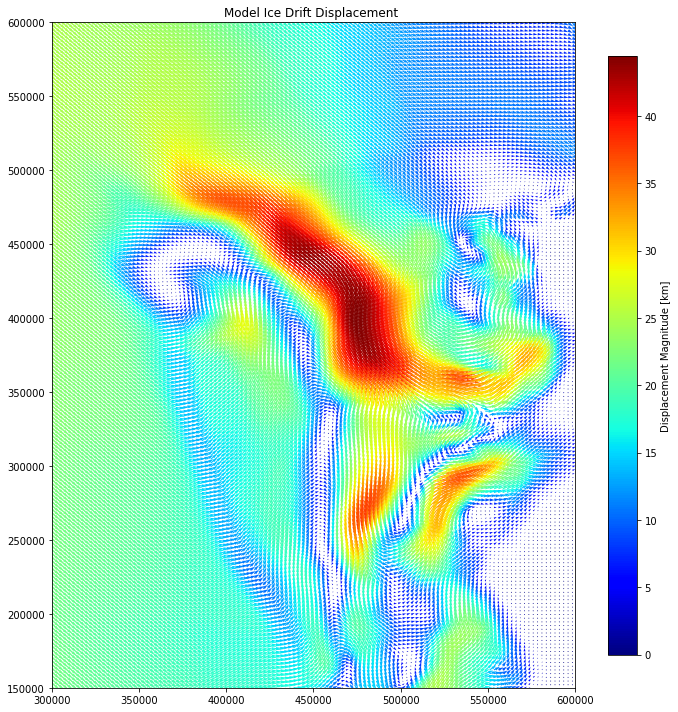

In [32]:
import numpy as np
import matplotlib.pyplot as plt

u = model_u / 1000  # convert to kilometers
v = model_v / 1000  # convert to kilometers
disp = np.sqrt((v**2 + u**2))  # calculate displacement magnitude

# Replace infinite values with NaN
disp = np.where(np.isinf(disp), np.nan, disp)

# Find global min and max displacement for the color range
disp_min = np.nanmin(disp)
disp_max = np.nanmax(disp)

# Close any existing figures
plt.close('all')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

quiv_params = {
    'scale': 900,
    'cmap': 'jet',
    'width': 0.002,
    'headwidth': 3,
    'clim': (disp_min, disp_max)
}

step = 1
# Create quiver plot
quiv = ax.quiver(x[::step], y[::step], u[::step], v[::step], disp[::step], **quiv_params)

# Colorbar with shared color scale
cbar = fig.colorbar(quiv, ax=ax, orientation='vertical', shrink=0.9)
cbar.set_label('Displacement Magnitude [km]')

# Set the x and y limits for the axis
ax.set_xlim([300000, 600000])
ax.set_ylim([150000, 600000])

# Title of the plot
ax.set_title(f'Model Ice Drift Displacement ')

# Set background color to white
fig.set_facecolor('white')

# Adjust layout for tight fit
plt.tight_layout()

# Show the plot
plt.show()
